In [ ]:
# -*- coding: utf-8 -*-
"""
Created on May 27, 2024
Last modified on May 27, 2024
@Author: Guan-Fu Liu

To test the read_results.py
"""
from read_results import *
import re

In [ ]:
# file_path = "./outputs/ChemEvo_galIMF_set.h5"
file_path = "./outputs/ChemEvo_N13.h5"
yield_files, groups, ElemNotice, dfs, ElemIntersect, SNIaOn, mass_lifetime_file, mass_lifetime, SFH, StarInitElement,\
             StellarMass, SNccNum, SNIaNum, AGB_Num, GasElement, ZGas, EjectElement, SNccElement, SNIaElement,\
             AGB_Element, YieldsTable, IMF_type, IMF_data, creation_time, SFE, \
             interp_kind, comments, solar_set = read_results(file_path)

In [ ]:
from matplotlib.gridspec import GridSpec
%matplotlib widget
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
axes = { }
for i, elem in enumerate(ElemNotice):
    axes[elem] = fig.add_subplot(gs[i//3, i%3])
    norm = EjectElement[:, constants.elem_names.index(elem)].max()
    line1, = axes[elem].plot(SFH['Age']/1e9, EjectElement[:, constants.elem_names.index(elem)]/norm,
                              '--*', markersize=4, label="Total ejecta")
    line2, = axes[elem].plot(SFH['Age']/1e9, SNccElement[:, constants.elem_names.index(elem)]/norm,
                              '-<', markersize=4, label="SNcc ejecta")
    line3, = axes[elem].plot(SFH['Age']/1e9, AGB_Element[:, constants.elem_names.index(elem)]/norm,
                              '-.d', markersize=4, label="AGB ejecta")
    line4, = axes[elem].plot(SFH['Age']/1e9, SNIaElement[:, constants.elem_names.index(elem)]/norm,
                              '-->', markersize=4, label="SNIa ejecta")
    if i not in [9, 10, 11]:
        axes[elem].set_xticklabels([])
    if i not in [0, 3, 6, 9]:
        axes[elem].set_yticklabels([])
    axes[elem].annotate(elem, xy=(0.85, 0.85), xycoords='axes fraction')

fig.supxlabel("Time [Gyr]", y=0.08)
fig.supylabel(r"Normalized Mass", x=0.085)
fig.legend((line1, line2, line3, line4), ("Total ejecta", "SNcc ejecta", "AGB ejecta", "SNIa ejecta"), loc=(0.35, 0.89), ncol=4)
deviation = np.abs(EjectElement.cumsum(axis=0)-SNccElement.cumsum(axis=0)-AGB_Element.cumsum(axis=0)-SNIaElement.cumsum(axis=0))
mask = EjectElement>0
deviation = deviation[mask]
deviation = deviation / EjectElement.cumsum(axis=0)[mask]
deviation = deviation.max()
fig.suptitle("The maximum cumulative deviation is %0.4e" % deviation, y=0.92)
# fig.savefig("Ejecta-all-N13.pdf", dpi=300)
plt.show()
print(np.abs(EjectElement-SNccElement-AGB_Element-SNIaElement).max())

In [ ]:
if SNIaOn:
    dir1 = "1square-SNIaON"
else:
    dir1 = "1square-SNIaOFF"

filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(3*4, 4*3))
axes = axes.flatten()
for idx in range(len(Zis)):
    ax = axes[idx]
    Zi = Zis[idx]
    Zj = Zjs[idx]
    correct_factor = constants.abund_tables["AG"][constants.elem_names.index(Zi)]\
        /constants.abund_tables["AG"][constants.elem_names.index(Zj)]\
        *constants.abund_tables[solar_set][constants.elem_names.index(Zj)]\
        /constants.abund_tables[solar_set][constants.elem_names.index(Zi)]
    Zi2Zj = { }
    Zi2Zj["galIMF-%s/%s"%(Zi,Zj)] = 10**np.array(lines[line_num[idx]].split(), dtype=float)*correct_factor
    Zi2Zj.update(GetZi2Zj(GasElement, Zi, Zj, solar_set, fill_value=None))
    ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,Zj)]], Zi2Zj['%s/%s'%(Zi,Zj)], 'b--', label='%s/%s in ChemEvoIMF'%(Zi,Zj))
    ax.plot(t, Zi2Zj["galIMF-%s/%s"%(Zi,Zj)], 'r-', label="%s/%s in galIMF"%(Zi,Zj))
    ax.set_ylabel('%s/%s'%(Zi,Zj))
    ax.legend()

fig.supxlabel('Age (yr)')
fig.supylabel('X/Y')

if SNIaOn:
    fig.suptitle("ChemEvoIMF vs galIMF, with SNIa")
    fig.tight_layout()
    # fig.savefig("ChemEvoIMF_vs_galIMF_SNIaON.pdf")
else:
    fig.suptitle("ChemEvoIMF vs galIMF, No SNIa")
    fig.tight_layout()
    # fig.savefig("ChemEvoIMF_vs_galIMF_SNIaOFF.pdf")
plt.show()

In [ ]:
mask = SNccNum.cumsum()>0
imf = IMF(IMF_type=list(IMF_data.keys())[0]).imf
frac = quad(imf, constants.AGB_min, constants.AGB_max)[0] / quad(imf, constants.SNcc_min, constants.SNcc_max)[0]
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(SFH['Age'][mask], AGB_Num.cumsum()[mask]/SNccNum.cumsum()[mask], 'r-', label="ChemEvoIMF")
ax.hlines(frac, SFH['Age'][mask][0], SFH['Age'][mask][-1], linestyles='--', label="Theoretical maximum")
ax1 = ax.twinx()
ax1.plot(SFH['Age'][mask], SFH['SFR'][mask], 'b-.', label="SFR")
ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
ax.set_xlabel("Time (yr)")
ax.set_ylabel("#AGB/SNcc")
ax.set_title("Number ratio of AGB events to SNcc events")
# fig.savefig("AGB_SNcc.pdf")
plt.show()

In [ ]:
mask = SNccNum.cumsum()>0
imf = IMF(IMF_type=list(IMF_data.keys())[0]).imf
frac = quad(imf, constants.AGB_min, constants.AGB_max)[0] / quad(imf, constants.SNcc_min, constants.SNcc_max)[0]
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(SFH['Age'][mask], AGB_Num.cumsum()[mask]/SNccNum.cumsum()[mask], 'r-', label="ChemEvoIMF")
ax.hlines(frac, SFH['Age'][mask][0], SFH['Age'][mask][-1], linestyles='--', label="Theoretical maximum")
ax1 = ax.twinx()
ax1.plot(SFH['Age'][mask], SFH['SFR'][mask], 'b-.', label="SFR")
ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
ax.set_xlabel("Time (yr)")
ax.set_ylabel("#AGB/SNcc")
ax.set_title("Number ratio of AGB events to SNcc events")
# fig.savefig("AGB_SNcc.pdf")
plt.show()

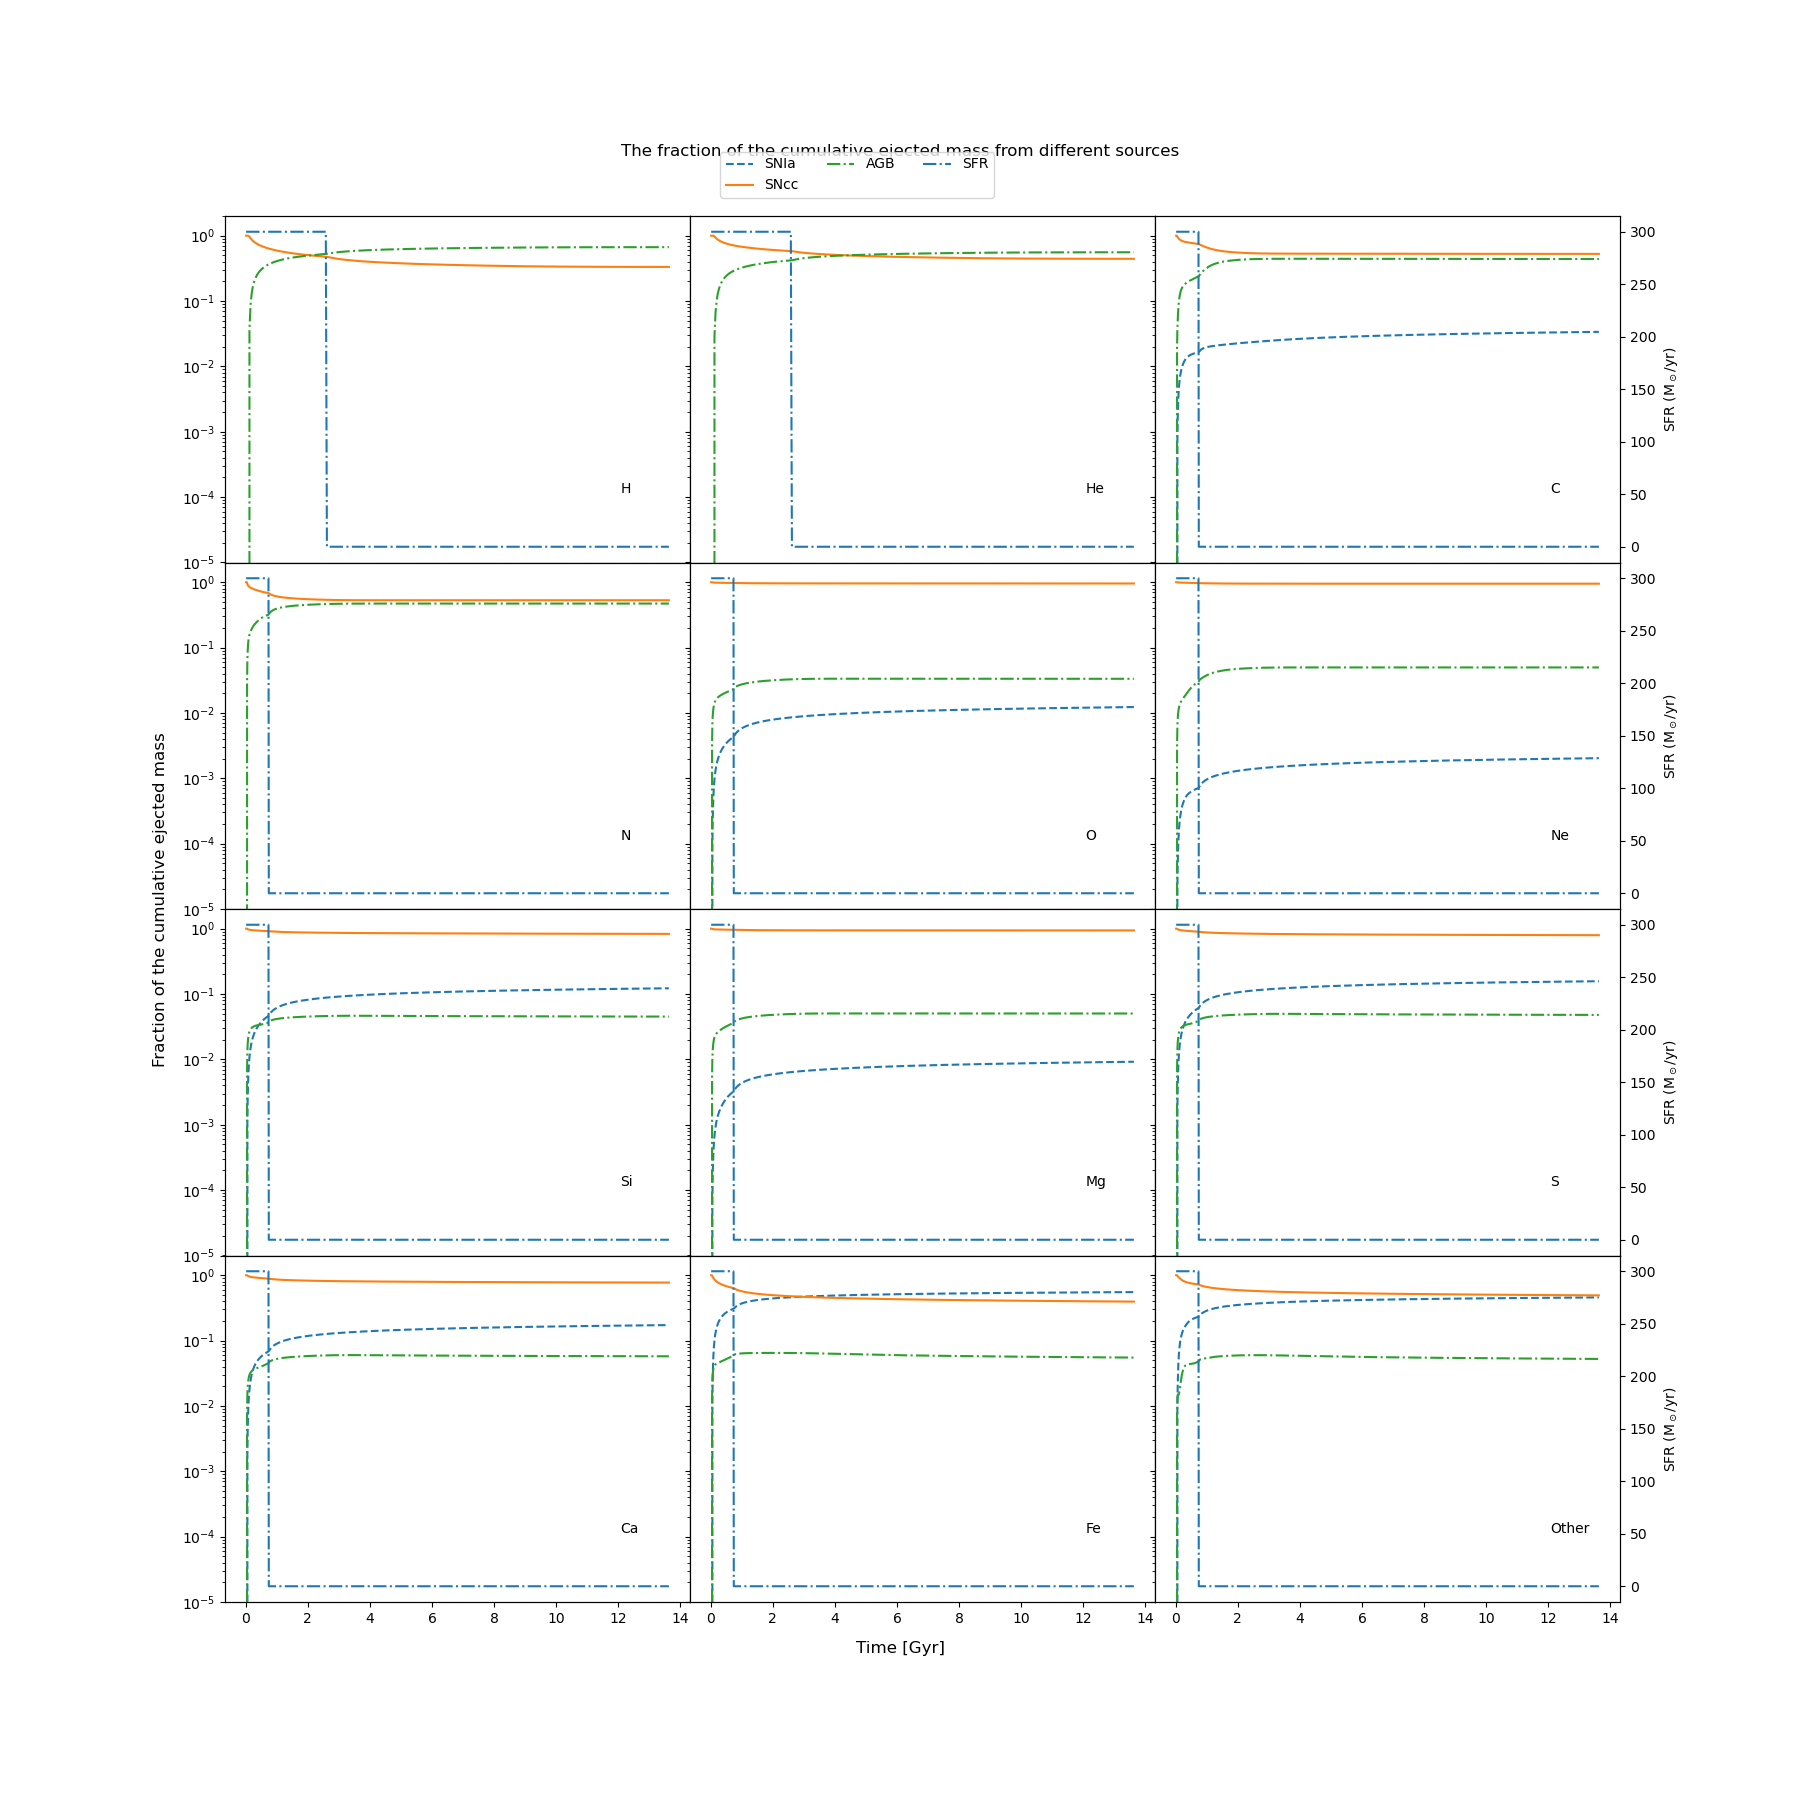

In [30]:
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
for i, elem in enumerate(ElemNotice):
    ax = fig.add_subplot(gs[i])
    mask = EjectElement[:, constants.elem_names.index(elem)]>0
    frac_SNIa = SNIaElement[:, constants.elem_names.index(elem)][mask].cumsum()/\
                EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
    frac_SNcc = SNccElement[:, constants.elem_names.index(elem)][mask].cumsum()/\
                EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
    frac_AGB = AGB_Element[:, constants.elem_names.index(elem)][mask].cumsum()/\
                EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
    line1, = ax.plot(SFH['Age'][mask]/1e9, frac_SNIa, '--', markersize=4, label="SNIa")
    line2, = ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, '-', markersize=4, label="SNcc")
    line3, = ax.plot(SFH['Age'][mask]/1e9, frac_AGB, '-.', markersize=4, label="AGB")

    ax1 = ax.twinx()
    line4, = ax1.plot(SFH['Age'][mask]/1e9, SFH['SFR'][mask], '-.', label="SFR")
    if i in [2, 5, 8, 11]:
        ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
    else:
        ax1.set_yticklabels([])
    ax.annotate(elem, xy=(0.85, 0.2), xycoords='axes fraction')
    ax.set_ylim(1e-5, 2)
    ax.set_yscale('log')
    if i not in [9, 10, 11]:
        ax.set_xticklabels([])
    if i not in [0, 3, 6, 9]:
        ax.set_yticklabels([])
fig.supxlabel("Time [Gyr]", y=0.08)
fig.supylabel("Fraction of the cumulative ejected mass", x=0.085)
fig.legend((line1, line2, line3, line4), ("SNIa", "SNcc", "AGB", "SFR"), loc=(0.40, 0.89), ncol=3)
fig.suptitle("The fraction of the cumulative ejected mass from different sources", y=0.92)
fig.savefig("Ejecta_fraction_N13.pdf", dpi=300)

In [ ]:
plt.close("all")

In [ ]:
elem = "O"
mask = EjectElement[:, constants.elem_names.index(elem)]>0
frac_SNIa = SNIaElement[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
frac_SNcc = SNccElement[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
frac_AGB = AGB_Element[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
fig, ax = plt.subplots()
ax.plot(SFH['Age'][mask]/1e9, frac_SNIa, '--', label="SNIa")
ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, '-', label="SNcc")
ax.plot(SFH['Age'][mask]/1e9, frac_AGB, '-.', label="AGB")
ax.set_ylim(1e-5, 1.2)
ax.set_yscale('log')
ax.legend()
ax.set_xlabel("Time [Gyr]")
ax.set_ylabel("Cumulative Fraction")
ax.set_title("Cumulative Fraction of %s ejecta"%elem)
plt.show()

In [ ]:
mask = SNIaNum > 0
frac_SNcc = SNccNum[mask].cumsum()/SNIaNum[mask].cumsum()
fig, ax = plt.subplots()
ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, '-')
# ax.set_ylim(0, 1.1)
ax.set_xlabel("Time [Gyr]")

In [ ]:
mask = (SNIaElement[:, constants.elem_names.index("Fe")] > 0) | (SNccElement[:, constants.elem_names.index("Fe")] > 0)
SNIaElement[mask, constants.elem_names.index("Fe")].cumsum()/(SNIaElement[mask, constants.elem_names.index("Fe")].cumsum()+
                                                              SNccElement[mask, constants.elem_names.index("Fe")].cumsum())

In [ ]:
p_denominator=4.819420e-04
p_numerator=1.575560e-04
p_preset = p_numerator/p_denominator
quad(lambda m: m**(-2.35), 8, 150)[0]/quad(lambda m: m**(-2.35), 1.5, 8)[0]/p_preset

In [ ]:
SNIaElement[:, constants.elem_names.index("Fe")].sum()/\
(SNccElement[:, constants.elem_names.index("Fe")].sum() + SNIaElement[:, constants.elem_names.index("Fe")].sum())

In [ ]:
SNccNum.sum()/SNIaNum.sum()

In [ ]:
EjectElement[:, constants.elem_names.index(elem)]

In [ ]:
SNIaElement[:, constants.elem_names.index(elem)]

In [ ]:
Zi2Zj = { }
Zi2Zj.update(GetZi2Zj(GasElement, "Fe", "H", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "C", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "N", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "O", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Ne", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Mg", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Si", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "S", "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Ca", "Fe", solar_set, fill_value=None))

fig = plt.figure(figsize=(6*4, 4.5*2))
gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1], wspace=0, hspace=0)
axes = { }
axes['1'] = fig.add_subplot(gs[0])
axes['2'] = fig.add_subplot(gs[1])
axes['3'] = fig.add_subplot(gs[2])
axes['4'] = fig.add_subplot(gs[3])
axes['5'] = fig.add_subplot(gs[4])
axes['6'] = fig.add_subplot(gs[5])
axes['7'] = fig.add_subplot(gs[6])
axes['8'] = fig.add_subplot(gs[7])

Zi_list = ['C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca']

for i, elem in enumerate(Zi_list):
    ax = axes["%d"%(Zi_list.index(elem)+1)]
    ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj["[%s/Fe]"%elem], '-')
    ax.annotate(elem, xy=(0.05, 0.9), xycoords='axes fraction')
    ax.set_ylim(-1.2, 1.5)
    minor_yticks = np.arange(-1.2, 1.5, 0.1)
    ax.set_yticklabels([])
    ax.set_yticks(minor_yticks, minor=True)
    ax1 = ax.twinx()
    ax1.set_ylim(-20,320)
    line1 = ax1.plot(Zi2Zj["[Fe/H]"], SFH['SFR'][Zi2Zj['Fe/H-mask']], 'g-.')
    ax1.set_yticks([])

major_yticks = np.arange(-1, 1.5+0.5, 0.5)
axes["1"].set_ylabel("[X/Fe]")
axes["1"].set_yticks(major_yticks)
axes["1"].set_yticklabels(major_yticks)
axes["5"].set_ylabel("[X/Fe]")
axes["5"].set_yticks(major_yticks)
axes["5"].set_yticklabels(major_yticks)
major_twin_yticks = np.arange(0, 300+50, 50)
ax1 = axes["4"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)
ax1 = axes["8"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)

fig.legend(line1, ['SFR'], loc=[0.8, 0.89])
fig.supylabel('[X/Fe]')
fig.supxlabel('[Fe/H]')
fig.savefig("ChemEvoIMF_N13.pdf", dpi=300)
plt.show()

In [ ]:
Zi2Zj_e = { }
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Fe", "H", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "C", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "N", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "O", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Ne", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Mg", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Si", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "S", "Fe", solar_set, fill_value=None))
Zi2Zj_e.update(GetZi2Zj(EjectElement, "Ca", "Fe", solar_set, fill_value=None))

fig = plt.figure(figsize=(6*4, 4.5*2))
gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1], wspace=0, hspace=0)
axes = { }
axes['1'] = fig.add_subplot(gs[0])
axes['2'] = fig.add_subplot(gs[1])
axes['3'] = fig.add_subplot(gs[2])
axes['4'] = fig.add_subplot(gs[3])
axes['5'] = fig.add_subplot(gs[4])
axes['6'] = fig.add_subplot(gs[5])
axes['7'] = fig.add_subplot(gs[6])
axes['8'] = fig.add_subplot(gs[7])

Zi_list = ['C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca']

for i, elem in enumerate(Zi_list):
    ax = axes["%d"%(Zi_list.index(elem)+1)]
    ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj_e["[%s/Fe]"%elem], '-')
    ax.annotate(elem, xy=(0.05, 0.9), xycoords='axes fraction')
    ax.set_ylim(-1.2, 1.5)
    minor_yticks = np.arange(-1.2, 1.5, 0.1)
    ax.set_yticklabels([])
    ax.set_yticks(minor_yticks, minor=True)
    ax1 = ax.twinx()
    ax1.set_ylim(-20,320)
    line1 = ax1.plot(Zi2Zj["[Fe/H]"], SFH['SFR'][Zi2Zj['Fe/H-mask']], 'g-.')
    ax1.set_yticks([])

major_yticks = np.arange(-1, 1.5+0.5, 0.5)
axes["1"].set_ylabel("[X/Fe]")
axes["1"].set_yticks(major_yticks)
axes["1"].set_yticklabels(major_yticks)
axes["5"].set_ylabel("[X/Fe]")
axes["5"].set_yticks(major_yticks)
axes["5"].set_yticklabels(major_yticks)
major_twin_yticks = np.arange(0, 300+50, 50)
ax1 = axes["4"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)
ax1 = axes["8"].twinx()
ax1.set_ylabel(r"SFR ($M_{\odot}/yr$)")
ax1.set_ylim(-20,320)
ax1.set_yticks(major_twin_yticks)
ax1.set_yticklabels(major_twin_yticks)

fig.legend(line1, ['SFR'], loc=[0.8, 0.89])
fig.supylabel('[X/Fe] of Ejecta')
fig.supxlabel('[Fe/H]')
fig.savefig("ChemEvoIMF_Ejecta_N13.pdf", dpi=300)
plt.show()